In [ ]:
pip install pytorch_lightning

Python interpreter will be restarted.
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=c62b8f463105cd08d98d49610d26c490bd022913ea7ee25b7bc54e65c3ba93f2
  Stored in directory: /root/.cache/pip/wheels/2a/93/86/8cd17bc6c40fb605c3ac549d0b860ef7e84ee5f67bf01a3287
Successfully built fire
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-48179021-bed9-4419-b2b1-2242c0e15e3d
    Can't uninstall 'typing-extensions'. No files were found to uninstall.
Python interpreter will be restarted.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.functional import accuracy, precision, recall, f1_score

import mlflow.pytorch
import pytorch_lightning as pl
from mlflow import MlflowClient

In [ ]:
churn_df = pd.read_csv('/dbfs/FileStore/datasets/Churn_Modelling.csv')

churn_df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
churn_df.isnull().sum()

Out[3]: CustomerId         0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [ ]:
churn_df.drop(labels = ['CustomerId'], axis = 1, inplace = True)

churn_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Out[5]: <AxesSubplot:xlabel='Exited', ylabel='count'>

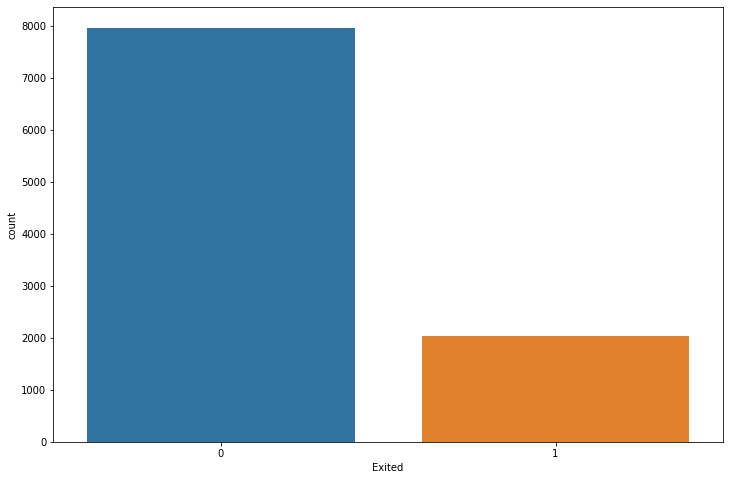

In [ ]:
plt.figure(figsize = (12, 8))

sns.countplot(data = churn_df,  x = 'Exited')

Out[6]: <AxesSubplot:xlabel='Exited', ylabel='Age'>

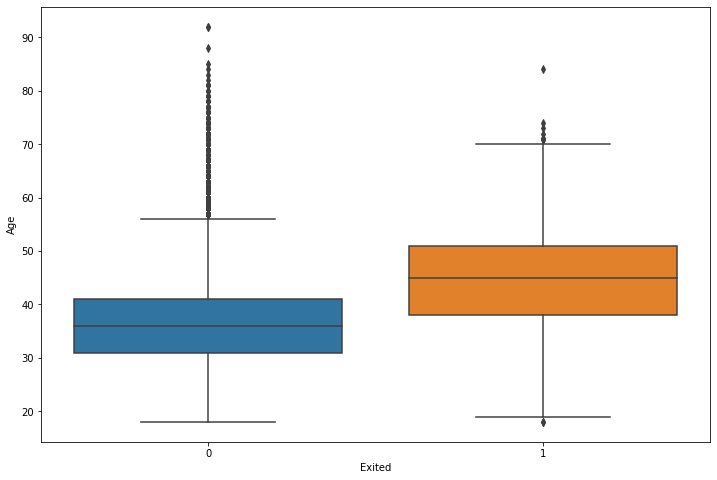

In [ ]:
plt.figure(figsize = (12, 8))

sns.boxplot(data = churn_df, x = 'Exited', y = 'Age')

Out[7]: <AxesSubplot:>

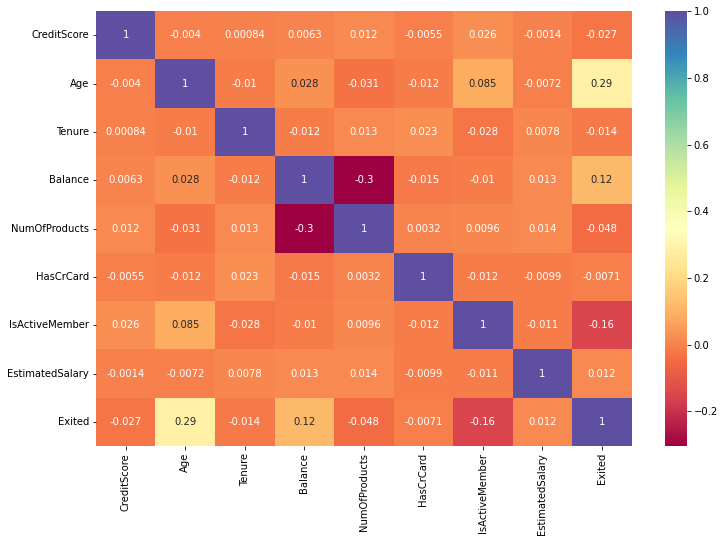

In [ ]:
plt.figure(figsize = (12, 8))

sns.heatmap(churn_df.corr(), annot = True, cmap = 'Spectral')

In [ ]:
churn_df = pd.get_dummies(data = churn_df, drop_first = True)

churn_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [ ]:
X = churn_df.drop(labels = ['Exited'], axis = 1)

y = churn_df['Exited'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

Out[9]: ((8000, 11), (2000, 11), (8000,), (2000,))

In [ ]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
X_train

Out[11]: array([[ 0.35476836, -0.18423398, -1.38231111, ...,  1.72286214,
        -0.57484841,  0.9111777 ],
       [ 0.30282874, -0.2796117 , -0.69212613, ..., -0.58042949,
        -0.57484841, -1.09748077],
       [ 0.02235481, -0.08885627,  0.34315135, ..., -0.58042949,
         1.73958906, -1.09748077],
       ...,
       [ 0.23011328,  0.38803232, -0.34703364, ..., -0.58042949,
        -0.57484841, -1.09748077],
       [-0.60092059, -0.75650029, -1.03721862, ..., -0.58042949,
        -0.57484841, -1.09748077],
       [-1.79553176, -1.42414431, -1.03721862, ...,  1.72286214,
        -0.57484841, -1.09748077]])

In [ ]:
X_test

Out[12]: array([[-1.85403655e-01, -1.51952202e+00, -6.92126127e-01, ...,
         1.72286214e+00, -5.74848406e-01,  9.11177697e-01],
       [-5.80144740e-01, -6.61122569e-01, -3.47033636e-01, ...,
         1.72286214e+00, -5.74848406e-01, -1.09748077e+00],
       [ 3.85932126e-01, -5.65744851e-01,  1.37842882e+00, ...,
         1.72286214e+00, -5.74848406e-01,  9.11177697e-01],
       ...,
       [ 2.40501200e-01, -1.84233983e-01, -3.47033636e-01, ...,
        -5.80429492e-01, -5.74848406e-01,  9.11177697e-01],
       [ 1.19668876e-02, -1.23338887e+00, -1.94114526e-03, ...,
         1.72286214e+00, -5.74848406e-01,  9.11177697e-01],
       [ 2.07916362e+00, -2.79611700e-01, -6.92126127e-01, ...,
        -5.80429492e-01, -5.74848406e-01,  9.11177697e-01]])

In [ ]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

y_train = y_train.view(len(y_train), 1)
y_test = y_test.view(len(y_test), 1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

Out[13]: (torch.Size([8000, 11]),
 torch.Size([2000, 11]),
 torch.Size([8000, 1]),
 torch.Size([2000, 1]))

In [ ]:
class ChurnDataModule(pl.LightningDataModule):
    def __init__(self, X_train, X_test, y_train, y_test):
        super().__init__()

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    def train_dataloader(self):
        input = self.X_train
        target = self.y_train

        dataset = TensorDataset(input, target)

        print(input.shape, target.shape)

        return DataLoader(dataset, batch_size = 128, num_workers=4)

    def test_dataloader(self):
        input = self.X_test
        target = self.y_test

        dataset = TensorDataset(input, target)

        print(input.shape, target.shape)

        return DataLoader(dataset, batch_size = 128, num_workers=4)

In [ ]:
churn_dm = ChurnDataModule(X_train, X_test, y_train, y_test)

churn_dm

Out[15]: <__main__.ChurnDataModule at 0x7fee2e50e5e0>

In [ ]:
train_dl = churn_dm.train_dataloader()

len(train_dl)

torch.Size([8000, 11]) torch.Size([8000, 1])
Out[16]: 63

In [ ]:
test_dl = churn_dm.test_dataloader()

len(test_dl)

torch.Size([2000, 11]) torch.Size([2000, 1])
Out[17]: 16

In [ ]:
class ChurnModel(pl.LightningModule):
    def __init__(self, num_input_features, lr = 0.01):
        super(ChurnModel, self).__init__()

        self.save_hyperparameters()

        self.linear1 = nn.Linear(num_input_features, 16)
        self.linear2 = nn.Linear(16, 8)
        self.linear3 = nn.Linear(8, 1)

    def forward(self, xb):

        prediction = torch.sigmoid(input = self.linear1(xb))
        prediction = torch.sigmoid(input = self.linear2(prediction))
        prediction = torch.sigmoid(input = self.linear3(prediction))

        return prediction

    def training_step(self, batch, batch_idx):
        input, target = batch

        logits = self.forward(input)

        train_loss = F.binary_cross_entropy(logits, target)
        train_acc = accuracy(logits, target.int())
        train_precision_score = precision(logits, target.int())
        train_recall_score = recall(logits, target.int())

        metrics = {'train_loss': train_loss, 'train_acc': train_acc,
                   'train_precision': train_precision_score, 'train_recall': train_recall_score}

        self.log_dict(metrics, on_step = False, on_epoch = True,
                      prog_bar = True)

        return train_loss

    def test_step(self, batch, batch_idx):
        input, target = batch

        logits = self.forward(input)

        test_loss = F.binary_cross_entropy(logits, target)
        test_acc = accuracy(logits, target.int())
        test_precision_score = precision(logits,  target.int())
        test_recall_score = recall(logits,  target.int())

        metrics = {'test_loss': test_loss, 'test_acc': test_acc,
                   'test_precision': test_precision_score, 'test_recall': test_recall_score}

        self.log_dict(metrics, on_step = False, on_epoch = True,
                      prog_bar = True)

        return test_acc

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = self.hparams.lr)

In [ ]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec

input_schema = Schema([
  ColSpec('double'),
  ColSpec('double'),
  ColSpec('double'),
  ColSpec('double'),
  ColSpec('double'),
  ColSpec('double'),
  ColSpec('double'),
  ColSpec('double'),
  ColSpec('double'),
  ColSpec('double'),
  ColSpec('double')
])

output_schema = Schema([ColSpec('double')])

In [ ]:
churn_model = ChurnModel(11)

trainer = pl.Trainer(max_epochs = 2000)

mlflow.pytorch.autolog()

with mlflow.start_run() as run:

    trainer.fit(churn_model, train_dl)
    trainer.test(dataloaders = test_dl, ckpt_path = 'best')

    signature = ModelSignature(inputs = input_schema, outputs = output_schema)

    mlflow.pytorch.log_model(churn_model, 'churn_prediction', signature = signature)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2022/11/10 02:55:58 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
Missing logger folder: /databricks/driver/lightning_logs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 192   
1 | linear2 | Linear | 136   
2 | linear3 | Linear | 9     
-----------------------------------
337       Trainable params
0         Non-trainable params
337       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2000` reached.
2022/11/10 03:17:29 WARNING mlflow.utils.requirements_utils: Found torch version (1.11.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==1.11.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/11/10 03:17:33 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.12.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torchvision==0.12.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Restoring states from the checkpoint path at /databricks/driver/lightning_logs/version_0/checkpoints/epoch=1999-step=126000.ckpt
Loaded model weights from checkpoint at /databricks/driver/li

Testing: 0it [00:00, ?it/s]

2022/11/10 03:17:34 WARNING mlflow.utils.requirements_utils: Found torch version (1.11.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==1.11.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8464999794960022
        test_loss           0.45185863971710205
     test_precision          0.676912248134613
       test_recall          0.4848880469799042
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
2022/11/10 03:17:37 WARNING ml

In [ ]:
model_name = 'churn_prediction'

model_version = mlflow.register_model(f'runs:/{run.info.run_id}/model', model_name)

print(model_version)

In [ ]:
client = MlflowClient()

client.transition_model_version_stage(
  name = model_name,
  version = model_version.version,
  stage = 'Production',
)

Out[22]: <ModelVersion: creation_timestamp=1668051455578, current_stage='Production', description='', last_updated_timestamp=1668051763721, name='churn_prediction', run_id='f08762c534174557a88d459ce1960082', run_link='', source='dbfs:/databricks/mlflow-tracking/90305651608176/f08762c534174557a88d459ce1960082/artifacts/model', status='READY', status_message='', tags={}, user_id='1980623222278766', version='1'>

In [ ]:
import os
os.environ['DATABRICKS_TOKEN'] = 'dapid56da83c7d24500n3b13ceab00b24045c-3'

In [ ]:
import os
import requests
import numpy as np
import pandas as pd
import json

def create_tf_serving_json(data):
    return {'inputs': {name: data[name].tolist() for name in data.keys()} if isinstance(data, dict) else data.tolist()}

def score_model(dataset):
    url = 'https://adb-8932797120739102.2.azuredatabricks.net/model/churn_prediction/1/invocations'
    headers = {'Authorization': f'Bearer {os.environ.get("DATABRICKS_TOKEN")}', 'Content-Type': 'application/json'}
    ds_dict = dataset.to_dict(orient='split') if isinstance(dataset, pd.DataFrame) else create_tf_serving_json(dataset)
    data_json = json.dumps(ds_dict, allow_nan=True)
    response = requests.request(method='POST', headers=headers, url=url, data=data_json)
    if response.status_code != 200:
        raise Exception(f'Request failed with status {response.status_code}, {response.text}')
    return response.json()

In [ ]:
X_test_numpy = X_test.detach().cpu().numpy()

X_test_numpy[:5]

Out[42]: array([[-0.18540366, -1.5195221 , -0.69212615,  0.7341523 , -0.90767115,
         0.6493972 , -1.0304638 ,  0.8222534 ,  1.7228621 , -0.5748484 ,
         0.9111777 ],
       [-0.58014476, -0.66112256, -0.34703365,  0.6955779 ,  0.81548244,
         0.6493972 ,  0.9704368 ,  1.0967362 ,  1.7228621 , -0.5748484 ,
        -1.0974808 ],
       [ 0.38593212, -0.5657449 ,  1.3784288 ,  0.9505554 ,  0.81548244,
         0.6493972 , -1.0304638 ,  0.37761638,  1.7228621 , -0.5748484 ,
         0.9111777 ],
       [-1.3488511 , -0.5657449 , -0.34703365,  1.276915  ,  0.81548244,
         0.6493972 ,  0.9704368 ,  1.1515388 , -0.5804295 , -0.5748484 ,
         0.9111777 ],
       [ 0.17817366,  0.2926546 ,  0.34315133, -1.2315063 , -0.90767115,
         0.6493972 , -1.0304638 , -0.19570515, -0.5804295 , -0.5748484 ,
         0.9111777 ]], dtype=float32)

In [ ]:
served_predictions = score_model(pd.DataFrame(X_test_numpy))

served_predictions_df = pd.DataFrame(served_predictions)
served_predictions_df = served_predictions_df.reset_index(drop = True)

served_predictions_df

***** <Response [200]>


,0
0,0.007890
1,0.161568
2,0.020342
3,0.102108
4,0.544289
...,...
1995,0.045855
1996,0.002726
1997,0.004729
1998,0.022915


In [ ]:
import os
import requests
import numpy as np
import pandas as pd
import json

def create_tf_serving_json(data):
  return {'inputs': {name: data[name].tolist() for name in data.keys()}}

def score_model(dataset):
  url = 'https://adb-1858010364734723.3.azuredatabricks.net/model/employee_promotion_prediction/1/invocations'
  headers = {'Authorization': f'Bearer {os.environ.get("DATABRICKS_TOKEN")}', 'Content-Type': 'application/json'}
  ds_dict = create_tf_serving_json(dataset)
  data_json = json.dumps(ds_dict, allow_nan=True)
  print(data_json)
  response = requests.request(method='POST', headers=headers, url=url, data=data_json)
  if response.status_code != 200:
    raise Exception(f'Request failed with status {response.status_code}, {response.text}')
  return response.json()


served_predictions = score_model(pd.DataFrame(X_test_numpy))

served_predictions_df = pd.DataFrame(served_predictions['predictions'])
served_predictions_df = served_predictions_df.reset_index(drop = True)

served_predictions_df

In [ ]:
import mlflow
logged_model = 'runs:/' + run.info.run_id + '/churn_prediction'

loaded_model = mlflow.pyfunc.load_model(logged_model)

loaded_model_predictions_df = loaded_model.predict(pd.DataFrame(X_test_numpy)).reset_index(drop = True)

loaded_model_predictions_df

,0
0,0.007890
1,0.161568
2,0.020342
3,0.102108
4,0.544289
...,...
1995,0.045855
1996,0.002726
1997,0.004729
1998,0.022915


Loaded and Served model predictions are compared.Both need to match. Predicted probabilities are probability of predicting '1' label.

In [ ]:
loaded_and_served_compare_df = pd.concat([served_predictions_df, loaded_model_predictions_df], axis = 1, ignore_index = True)

loaded_and_served_compare_df

,0,1
0,0.007890,0.007890
1,0.161568,0.161568
2,0.020342,0.020342
3,0.102108,0.102108
4,0.544289,0.544289
...,...,...
1995,0.045855,0.045855
1996,0.002726,0.002726
1997,0.004729,0.004729
1998,0.022915,0.022915


Rounding off sigmoid predictions to get binary predictions and comparing some predictions

In [ ]:
loaded_and_served_compare_df.round()[:15]

,0,1
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,1.0,1.0
5,1.0,1.0
6,0.0,0.0
7,0.0,0.0
8,1.0,1.0
9,0.0,0.0


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

y_test_numpy = y_test.detach().cpu().numpy()
served_predictions_numpy = served_predictions_df.to_numpy()

print('Test Accuracy score :', accuracy_score(y_test_numpy, np.round(served_predictions_numpy)))
print('Test Precision score :', precision_score(y_test_numpy, np.round(served_predictions_numpy)))
print('Test Recall score :', recall_score(y_test_numpy, np.round(served_predictions_numpy)))

Test Accuracy score : 0.8465
Test Precision score : 0.6779661016949152
Test Recall score : 0.4854368932038835
